# $\S 2$ Interpolation Methods 
---

In this lab, I will test three algorithms of solving no-linear equation about their correctness and efficiency, they are('*' is alternative to do): 
- Lagrange interpolation
- Newtonian interpolation
- cubic spline interpolation     
- Aitken interpolation*   
- Hermit interpolation*  
And then use them to solve two problems in instruction book.

## 1. realization of these algorithms 

In [300]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.interpolate as std

In [301]:
def vis(polat, f, x, lim=1):
    xx = np.linspace(x[0] - lim, x[-1] + lim, 100)
    y = f(xx)
    p = polat(x, f(x))
    yy = p(xx)
    plt.plot(xx,  y, label='original')
    plt.plot(xx, yy, label='interpolation', linestyle='--') 
    plt.scatter(x, f(x), marker='o', color='r', label='interpolation points')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(f'use {polat.__name__} interpolation')
    plt.legend()
    plt.show()

### 1.1. Lagrange Interpolation 

Formualr of Interpolation:   
given that $n+1$ points $(x_i, y_i),\ i\in\{0, 1, 2, ..., n\}$ on function $f(x)$ and the corresponding $f(x)$ value: $y_0, y_1, ..., y_n$. They follow the order: $x_0<x_1<x_2<...<x_n$. we can interplate it by following function with $n^{th}$ largrange method: 
$$
p_n(x) = \sum_{i=0}^{n} y_i\cdot l_i(x) \\ 
\Rightarrow \sum_{i=0}^{n} y_i \cdot \prod_{j=0, j \ne i}^{n} {x - x_j \over x_i - x_j} \tag{1}
$$

In [302]:
def lagrange(x: np.ndarray, y: np.ndarray):
    n = x.shape[0] - 1

    def ll(k, t):
        f = 1
        for j in range(n + 1): # calcualte l_i
            if j != k:
                f *= (t - x[j]) / (x[k] - x[j]) 

        return f
            
    def larg(t):  # O(k*n^2)
        p = 0
        for i in range(n + 1):
            p += ll(i, t) * y[i]

        return p
    
    return larg

### 1.2. Newtonian Interpolation 

Formualr of Interpolation:   
given that $n+1$ points $(x_i, y_i),\ i\in\{0, 1, 2, ..., n\}$ on function $f(x)$ and their corresponding $f(x)$ value: $y_0, y_1, ..., y_n$. They follow the order: $x_0<x_1<x_2<...<x_n$. we can interplate it by following function with $n^{th}$ Newtonian method: 
$$
p_n(x) = f(x_0) + \sum_{i=1}^{n} f[x_0, x_1,..., x_k] \cdot \omega_k(x) \tag{2}
$$
where $f[x_0, x_1, ..., x_k]$ is $k^{th}$ difference of $f(x)$ on interpolation points. 
it can be defined as: 
$$
f[x_1, ..., x_k] = {f[x_1, ..., x_{k-1}] - f[x_2, ..., x_k] \over x_1 - x_k} , \ f[x_i] = f(x_i) = y_i, i=0, 1, ..., n \tag{3}
$$
to make its calculation more easy, we use a table to assist our computation. (suppose that $n = 4$)
<center>

|$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ x\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $|$\ \ \ \ \ \ \ \ \ \ \ \ \ \ f(x)\ \ \ \ \ \ \ \ \ \ \ \ \ \ $|$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $|$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $ | $\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $|
|:---:|:---:|:---:|:---:|:---:|
|$x_0$|$f(x_0)$|||
|$x_1$|$f(x_1)$|$f[x_0, x_1]$| |
|$x_2$|$f(x_2)$|$f[x_1, x_2]$|$f[x_0, x_1, x_2]$| |
|$x_3$|$f(x_3)$|$f[x_2, x_3]$|$f[x_1, x_2, x_3]$|$f[x_0, x_1, x_2, x_3]$|
</center>

<center>

**Table 1.** difference table of origin function $f$ on interpolation points $x_0, ..., x_n$
</center>

The final result is the diagonal of this table. And to decrease spatial complexity, we use an arr to replace this table, and a special update method is applied here: we update this table from bottom. 

In [303]:
def newton(x: np.ndarray, y: np.ndarray): 
    n = x.shape[0] - 1
    arr = y.copy()
    for i in range(n):  # t: O(n^2), s: O(n)
        for j in range(n, i, -1):  # up date arr, calcualte diff table
            arr[j] = (arr[j] - arr[j - 1]) / (x[j] - x[j - 1 - i])

    def newtonf(var): # calculate interpolation function, O(k * n)
        p = 0
        w = 1
        for i in range(n + 1):
            p += arr[i] * w
            w *= var - x[i]

        return p
    return newtonf

### 1.3. Cubic spline interpolation 

Given $n+1$ sorted interpolation points: $x_0 < x_1 < ... < x_n$, and their corresponding $f(x)$ value: $y_0, y_1, ..., y_n$. Then we can use a series of cubic polynomial to interpolate $f(x)$ in intervals: $[x_i, x_{i+1}]$, where $i = 0, 1, ..., n-1$. The interpolation polynomial can be written as: 
$$
p(x) = {M_i \over 6h_i}(x-x_{i+1})^3 + {M_{i+1} \over 6h_i}(x_i-x)^3 + ({y_i\over h_i}-{M_i h_i \over 6})(x-x_{i+1}) + ({y_{i+1} \over h_i}-{M_{i+1} h_i \over 6})(x_i-x)
$$
where $M_i=f^{''}(x_i), i = 0, 1, ..., n$. These $M_i$ can be regarded as parameters that can be solved by following method:  
Suppose that $M = (M_1, M_2, ..., M_{n-1})$, we get: 
$$
M = A^{-1}(6\cdot T(2)-b)
$$
where:   
$$
A = 
\begin{bmatrix}
2 & \overline \omega_1  &  \\
\omega_2 & 2 & \overline \omega_2 \\
& \omega_2 & 2 & \overline \omega_2 \\
& \\
 &  &\ddots &\ddots & \ddots\\
& & & \omega_{n-2} & 2 & \overline \omega_{n-2} \\
& & & & \omega_{n-2} & 2 \\
\end{bmatrix}_{(n-1)\times(n-1)}
$$
$$
\omega_i = {h_{i-1} \over h_{i-1} + h_{i}},\ \overline \omega_i = 1-\omega_i,\ where\ i=1, 2, ..., n-1
$$
$$
h_i=x_i-x_{i+1},\ where\ i=0, 1,..., n-1
$$
and: 
$$
b=\begin{bmatrix} 
\omega_1 M_0 \\
0 \\
\vdots \\
0 \\
\overline \omega_{n-1} M_n\\
\end{bmatrix}_{(n-1) \times 1}, 
T(2) = \begin{bmatrix}
f[x_0, x_1, x_2] \\
f[x_1, x_2, x_3] \\
\vdots \\ 
f[x_{n-2}, x_{n-1}, x_n] \\
\end{bmatrix}_{(n-1)\times 1}
$$
why I'm going to call $T(2)$ is that $T(2)$ is the second column of difference table of newton's interpolation. 

In [304]:
def cubic_spline(x: np.ndarray, y: np.ndarray):
    n = x.shape[0] - 1
    h = [x[i] - x[i+1] for i in range(n)]  # len = n
    w = [h[i] / (h[i-1] + h[i]) for i in range(1, n)]  # len = n - 1

    A = np.zeros((n-1, n-1))
    A[0, 0], A[0, 1] = 2, 1 - w[0]
    for i in range(1, n-2):
        A[i, i - 1], A[i , i], A[i, i + 1] = w[i], 2, 1 - w[i]
    A[n-2, n-3], A[n-2, n-2] = w[n-2], 2

    arr = y.copy()  # copy y
    for i in range(2):  # time: O(n), space: O(n)
        for j in range(n, i, -1):  # up date arr, calcualte diff table
            arr[j] = (arr[j] - arr[j - 1]) / (x[j] - x[j - 1 - i])

    arr = np.array(arr)
    arr = arr[2:]

    M = np.linalg.inv(A) @ (6 * arr)  # O(n^3
    M = np.insert(M, 0, 0)
    M = np.append(M, 0)

    def cubs(val):
        ll = []
        for t in val:  # O(k * log(n))
            i = np.searchsorted(x, t) - 1 
            if i < 0:
                i = 0
            elif i > n - 1:
                i = n - 1

            ll.append(M[i]/(6*h[i])*(t-x[i+1])**3 + M[i+1]/(6*h[i])*(x[i]-t)**3 + (y[i]/h[i]-h[i]*M[i]/6)*(t-x[i+1]) + (y[i+1]/h[i]-h[i]*M[i+1]/6)*(x[i]-t))

        return np.array(ll)

    return cubs


### 1.4. Aitken Interpolation*

In [305]:
def aitken(x, y):
    pass

### 1.5. Hermit Interpolation*

In [306]:
def hermite(x, y):
    pass

## expriment

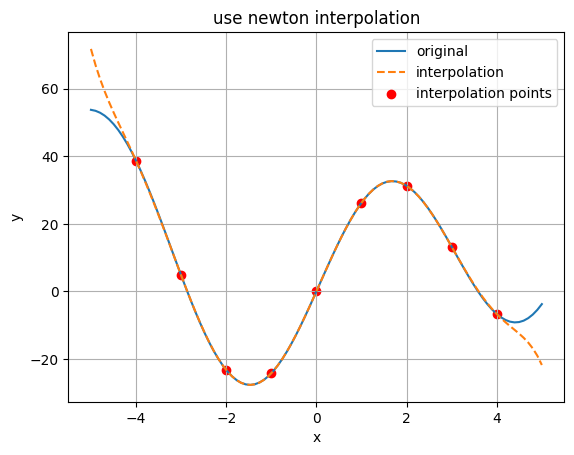

In [307]:
x = np.arange(-4, 5)
f = lambda x: x**2 + 30*np.sin(x)
vis(newton, f, x, 1)

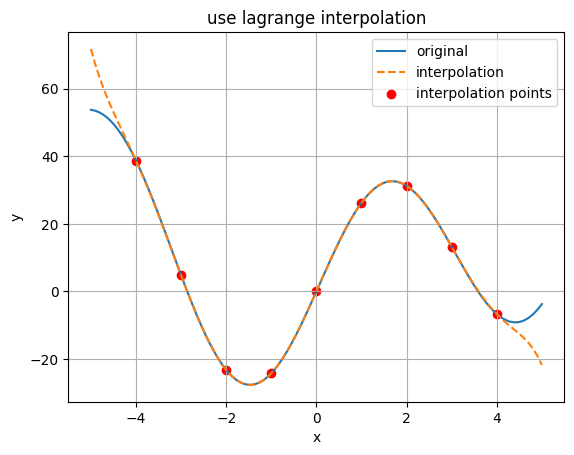

In [308]:
x = np.arange(-4, 5)
f = lambda x: x**2 + 30*np.sin(x)
vis(lagrange, f, x, 1)

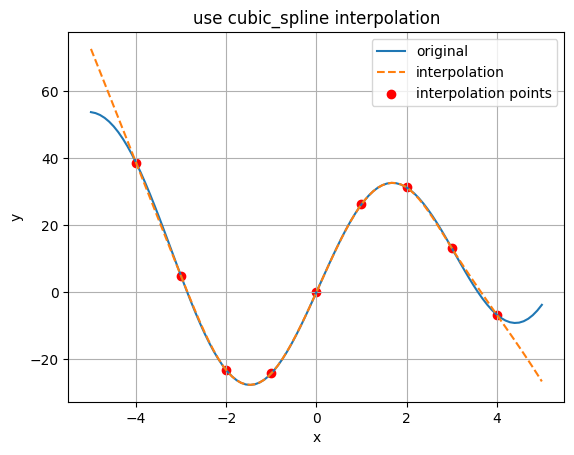

In [309]:
x = np.arange(-4, 5)
f = lambda x: x**2 + 30*np.sin(x)
vis(cubic_spline, f, x, 1)

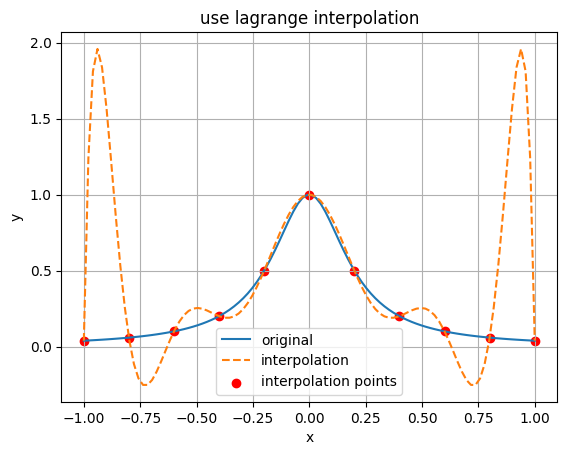

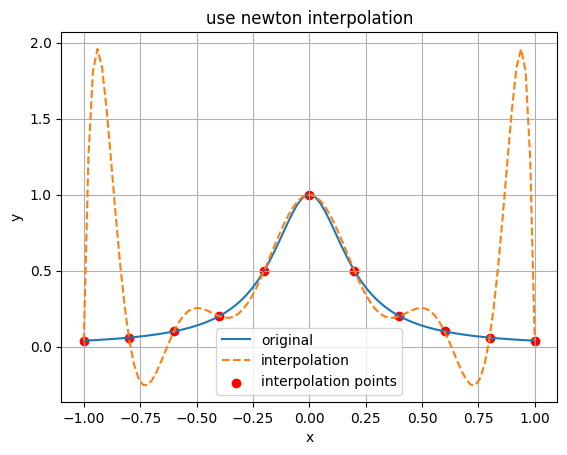

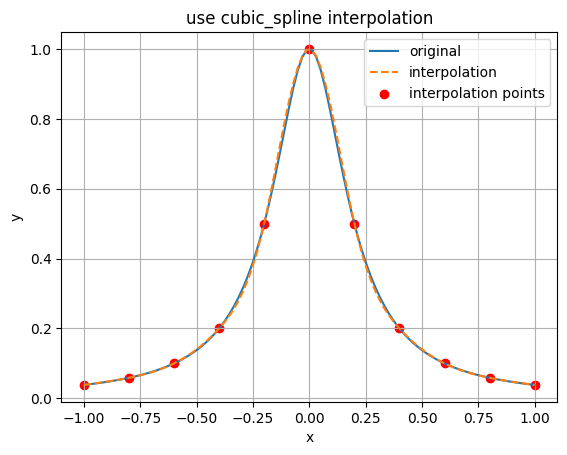

In [310]:
x = np.linspace(-1, 1, 11)
f = lambda x: 1 / (25 * x**2 + 1)
# p = lagrange(x, f(x))
# for t in x:
#     print(f'f(x) = {f(t):10.4f}, p(x) = {p(t):10.4f}')


vis(lagrange, f, x, lim=0)
vis(newton, f, x, lim=0)
vis(cubic_spline, f, x, lim=0)

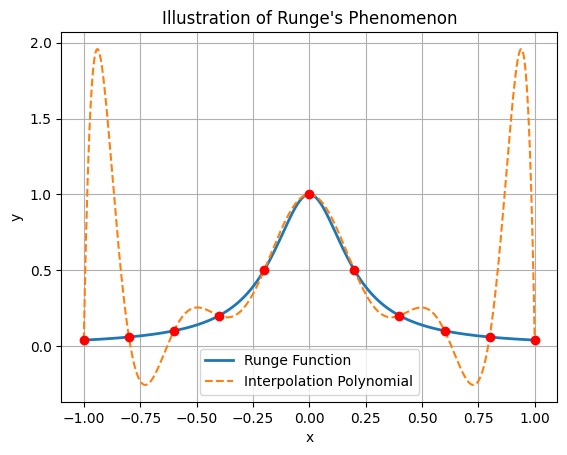

In [311]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

# 定义Runge函数
def runge(x):
    return 1 / (1 + 25 * x**2)

# 生成等距插值点
num_points = 11  # 选择插值点的数量
x_interp = np.linspace(-1, 1, num_points)
y_interp = runge(x_interp)

# 使用多项式进行插值
coeffs = np.polyfit(x_interp, y_interp, deg=num_points-1)
p = Polynomial(coeffs[::-1])  # 因为np.polyfit返回的系数顺序与Polynomial不同

# 绘制原函数和插值多项式
x_plot = np.linspace(-1, 1, 400)
plt.plot(x_plot, runge(x_plot), label='Runge Function', linewidth=2)
plt.plot(x_plot, p(x_plot), label='Interpolation Polynomial', linestyle='--')
plt.plot(x_interp, y_interp, 'ro')  # 插值点

plt.title("Illustration of Runge's Phenomenon")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()
